# 0. Imports

Steps before running this notebook : 
1. Launch the server in the '5000' port by running the batch 'LaunchLOBserver.cmd' and entering 5000 as port.
2. Visit the server address to make sure the server is running
3. Launch the agent's FIX server in the '5003' port by running the batch 'LaunchFIXserver.cmd' and entering 5003 as port.
4. Make sure you have installed ngrok

In [1]:
# Imports
from   IPython.display import display, HTML
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import logging
logging.basicConfig()
logging.getLogger('apscheduler').setLevel(logging.CRITICAL)

# Display options
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [2]:
import mimicLOB as lob
from mimicLOB.agent.genericAgent import genericAgent
from mimicLOB.utils import getInstance
from mimicLOB.information.channel import Channel
from mimicLOB.utils import getBookHistory

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint

# local & distant server
localserver = "http://127.0.0.1:5000"
distantserver = "http://fdr0903.pythonanywhere.com/"

# Server used
server = localserver

## Simulation configuration

#### Random Agent : a random agent is either a liquidity provider via limit order or a liquidity consumer via market orders. The agent has an intensity of sending order. 
#### Random agents react to exogenous news, their intensity of sending orders is shifted according to news arrival. 
#### News object is a random process between 0 & 100, 0 being the worst news and 100 very good news. For examples, buyers will buy more if the news are very good. This enables trends in prices.

#### Parameters :
1. distant : if true, the agent must have the server address. If False, he should have the orderbook object passed in the configuration.
2. server : when distant is True, the http address of the server the LOB is running on.
3. id : optional, default is generic. the if is used in the transaction tape.
4. b_record : optional, boolean, default is False. If True, the agent records all his activity : sent orders, executed trades, pending orders ...

5. FIXaddress : address & port on which the agent is listening to the LOB messages. Every agent should have a different port.

In [3]:
Simulationconfig = {'information' : {'basicInfo' : {'type'       : 'genericInformation',
                                                    'intensity'  : 0.03}},
                    'agents'      : {'agent1' : {'type'          : 'randomAgent',
                                                 'distant'       : True,
                                                 'server'        : server,
                                                 'subtype'       : 'randomLimitBuyer',
                                                 'id'            : 'agent1',
                                                 'intensity'     : 0.4,
                                                 'quantityRange' : [50, 200, 10]},
                                    'agent2' : {'type'          : 'randomAgent',
                                                 'distant'      : True,
                                                 'server'       : server,
                                                'subtype'       : 'randomMarketBuyer',
                                                 'id'           : 'agent2',
                                                'intensity'     : 0.4,
                                                'quantityRange' : [50, 200, 10]},
                                    'agent3' : {'type'          : 'randomAgent',
                                                 'distant'      : True,
                                                 'server'       : server,
                                                'subtype'       : 'randomLimitSeller',
                                                 'id'           : 'agent3',
                                                'intensity'     : 0.4,
                                                'quantityRange' : [50, 200, 10]},
                                    'agent4' : {'type'          : 'randomAgent',
                                                 'distant'      : True,
                                                 'server'       : server,
                                                'subtype'       : 'randomMarketSeller',
                                                 'id'           : 'agent4',
                                                'intensity'     : 0.4,
                                                'quantityRange' : [50, 200, 10]},
                                    'MM'     : {'type'          : 'basicMM',
                                                 'distant'      : True,
                                                 'server'       : server,
                                                 'id'           : 'MM',
                                                'refQuantity'   : 100,
                                                'refPrice'      : 100,
                                                'b_record'      : True,
                                                'FIXaddress'    : 'http://127.0.0.1:5003/'}}}

## Create News Information

In [4]:
# Channel (doubly linked chain of news)
newsChannel = Channel()

# keeps references on information sources
newsFactory = {}
config_news = Simulationconfig['information']
for info in config_news:
    config_news[info]['channel'] = newsChannel
    newsFactory[info] = getInstance('mimicLOB.information', config_news[info])

## Create the agents
The agents is constantly connected to the distant LOB via the server address or the LOB address.

In [5]:
agentFactory  = {} # keeps references on agents
config_agents = Simulationconfig['agents']

for agent in config_agents:
    config_agents[agent]['channel'] = newsChannel
    agentFactory[agent] = getInstance('mimicLOB.agent', config_agents[agent])   

In [6]:
# The market (LOB admin)
market = genericAgent(id = 'market', distant=True, server=server)

## Launch Trading

#### We launch trading

#### You have to execute the stop or pause command to stop simulation (wait a few seconds of trading at least)

In [7]:
from apscheduler.schedulers.background import BackgroundScheduler

sched = BackgroundScheduler()

def startSimulation():
    for agent in agentFactory:
        agentFactory[agent].start(sched)
        
    for news in newsFactory:
        newsFactory[news].start(sched)

In [8]:
sched.start()
startSimulation()

## Pause Trading
#### INFO : trading still continues, even if the previous cell is not 'running'. The aps scheduler executes tasks in the background !

In [18]:
try:
    sched.pause()
except Exception as e:
    print(e)

## Resume Trading

In [11]:
try:
    sched.resume()
except Exception as e:
    print(e)

## Stop Trading

In [ ]:
try:
    sched.shutdown()
except Exception as e:
    print(e)

In [15]:
# uncomment to reset lob : 
# market.resetLOB_PendingOrders()

## Get LOB

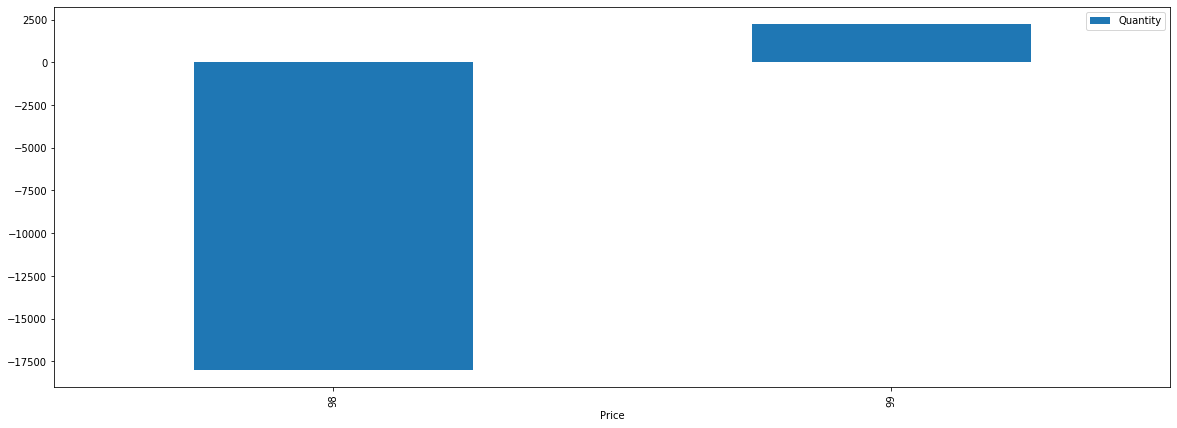

In [11]:
LOBstate = market.getLOBState()
LOBstate = LOBstate.set_index('Price').sort_index()
LOBstate.plot.bar(figsize=(20, 7))
plt.show()

## Get Price Tape

'open  : 99.0'

'high  : 102.0'

'low   : 97.0'

'close : 99.0'

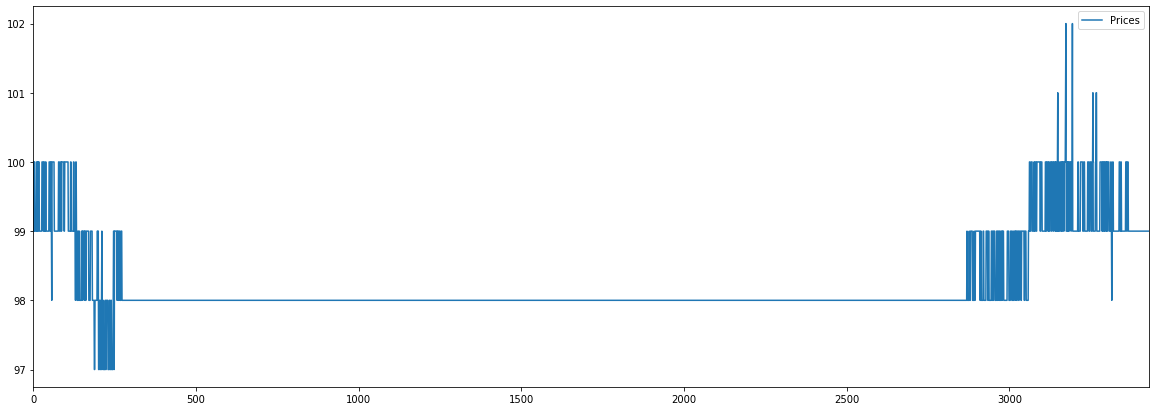

In [10]:
histoPrices = market.getPriceTape().astype(float)
histoPrices.plot(figsize=(20,7))

# OHLC
display(f'open  : {histoPrices.iloc[0,0]}')
display(f'high  : {histoPrices.max()[0]}')
display(f'low   : {histoPrices.min()[0]}')
display(f'close : {histoPrices.iloc[-1, 0]}')

plt.show()

## Get Transaction Tape

In [15]:
TransactionTape = market.getTransactionTape()

In [16]:
TransactionTape

,time,party1_id,party1_side,party1_order_id,party2_id,party2_side,party2_order_id,traded_price,traded_quantity
0,1587325034450132400,MM,bid,1,agent4,bid,NaN,99,100
1,1587325034492064800,agent3,ask,2,agent2,ask,NaN,100,70
2,1587325034994322800,agent1,bid,3,agent4,bid,NaN,99,110
3,1587325034997315500,agent3,ask,2,agent2,ask,NaN,100,20
4,1587325034997315500,agent3,ask,4,agent2,ask,NaN,100,60
...,...,...,...,...,...,...,...,...,...
2863,1587325338204332700,agent1,bid,2750,agent4,bid,NaN,98,34
2864,1587325338205329900,agent1,bid,2752,agent4,bid,NaN,98,126
2865,1587325338283553400,agent1,bid,2752,agent4,bid,NaN,98,6
2866,1587325338284551200,agent1,bid,2753,agent4,bid,NaN,98,81


## Get the MM book history

In [ ]:
executedTrades = pd.DataFrame.from_dict(agentFactory['MM'].executedtrades).T
executedTrades.set_index('time')

In [ ]:
# Book evolution :
book = getBookHistory(executedTrades, 'MM')

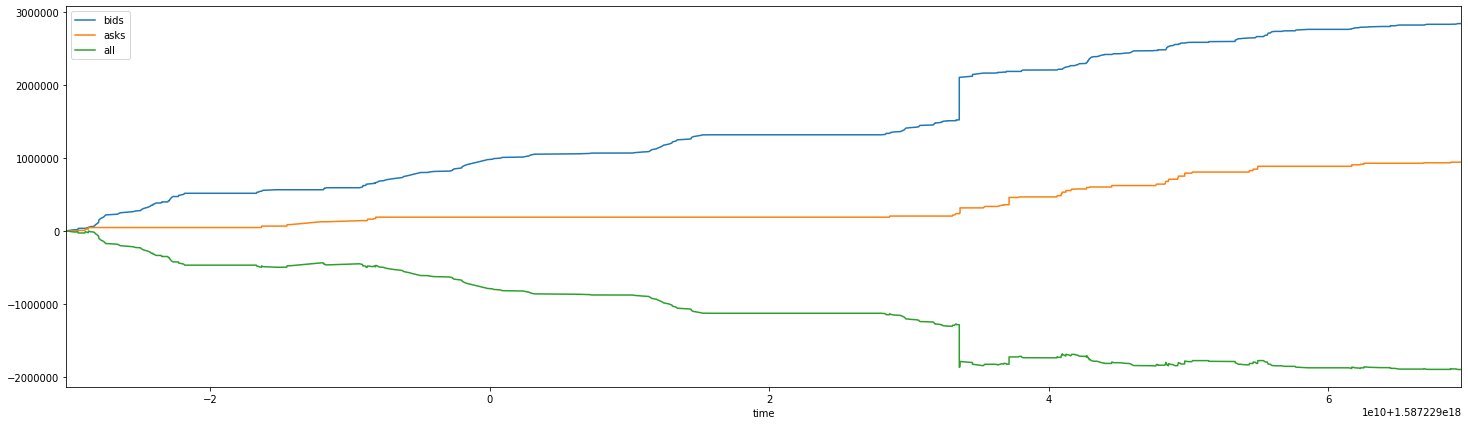

In [25]:
book.astype(float).plot(figsize=(25,7))